In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
from pyfim import pyeclat
from PD_freqitems import freqitemsets
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth, fpmax

In [2]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()

#we subtract 1 because the pids start at 1, the first 0 is never filled
#therefore the product with pid {pid} is at index {pid}-1
products=[0]* (len(lines)-1)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid) - 1]=pname
    
#read transactions
orders=pickle.load(open("order_products.pickle", "rb"))

#check products on order 2:
for prod in orders[2]: print(products[prod])

"Oikos Yogurt Drink, Strawberry"
Mild Italian Chicken Sausage
Organic Split Pea & Potato Soup
"Fajita Seasoning, Organic"
Belgian White Wheat Ale
Organic Green Leaf Lettuce
Zebra Cakes
Organic Fusilli No. 34
12 G. Protein Bar Coffee Chocolate


In [3]:
len(orders)

3214874

In [4]:
len(products)

49688

In [5]:
len(orders)*len(products)

159740659312

# Objective 1 - Analyze the itemset/rules generation procedure

In [6]:
encoder = TransactionEncoder().fit(orders.values())

In [7]:
binary_orders = encoder.transform(orders.values(), sparse=True)

In [8]:
binary_orders = pd.DataFrame.sparse.from_spmatrix(binary_orders)

In [9]:
binary_orders.head()

,0,1,2,3,4,5,6,7,8,9,...,49667,49668,49669,49670,49671,49672,49673,49674,49675,49676
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
order_list = orders.values()

##  From the approaches used in classes make a performance analysis up to a threshold level of support
Approaches considered in class:
 1. Apriori
 2. Fp-Growth
 3. ECLAT
 4. Naive

In [11]:
results = pd.DataFrame(columns = ["threshold", "n_itemsets", "apriori", "fp-growth", "eclat", "naive"])

In [12]:
thresholds = [0.03, 0.02, 0.01, 0.009, 0.007, 0.005, 0.003, 0.001, 0.0009, 0.0007, 0.0005, .0003]

In [13]:
results_list = [[np.nan for _ in range(len(thresholds))] for __ in range(4)]

In [21]:
#max number of iterations for each fqi function
caps = [3, float('inf'), 7, 6 ]

In [18]:
func = [apriori, fpgrowth, pyeclat, freqitemsets]
data = [binary_orders, order_list]

In [30]:
# performed each algorithm once at a time because of limited memory ( 16GB ) 
#index for the data source in the list {data}
data_index = 1
#index for the fqi function in the list {func}
func_index = 3

In [31]:
for i,thresh in enumerate(thresholds):
    if i>caps[func_index]:
        break
    start = time()
    fi = func[func_index](
        data[data_index], 
        thresh
    )
    stop = time() - start
    
    results_list[func_index][i] = stop
    results.loc[i] = {
        "threshold": thresh,
        "n_itemsets": len(fi),
        "apriori": results_list[0][i],
        "fp-growth": results_list[1][i],
        "eclat": results_list[2][i],
        "naive": results_list[3][i]
    }
    
    print(f"\nIteration {i}: Threshold = {thresh}")
    #print(results.loc[i])


Iteration 0: Threshold = 0.03

Iteration 1: Threshold = 0.02

Iteration 2: Threshold = 0.01

Iteration 3: Threshold = 0.009

Iteration 4: Threshold = 0.007

Iteration 5: Threshold = 0.005

Iteration 6: Threshold = 0.003


We performed the results for each algorithm, one at a time because of memory issues (16GB) <br>
When running we could verify that apriori algorithm consumes a lot more memory than the other 3 algorithms. With the others we can set the threshold value lower past $0.009$.

In [32]:
results

,threshold,n_itemsets,apriori,fp-growth,eclat,naive
0,0.0300,16,5.231888,17.803449,51.370993,33.533955
1,0.0200,39,15.067040,25.365873,54.439963,32.149916
2,0.0100,116,47.457986,37.385802,62.542033,49.390156
3,0.0090,138,83.149374,39.049573,60.503712,54.250201
4,0.0070,195,NaN,44.832170,70.383650,71.769270
5,0.0050,326,NaN,59.659715,83.585658,104.709220
6,0.0030,787,NaN,83.657007,125.846197,226.683366
7,0.0010,3883,NaN,158.392570,361.816962,NaN
8,0.0009,4542,NaN,166.549535,NaN,NaN
9,0.0007,6497,NaN,184.032964,NaN,NaN


In [33]:
results.to_csv("freq_itemsets_results.csv")

<Axes: xlabel='threshold'>

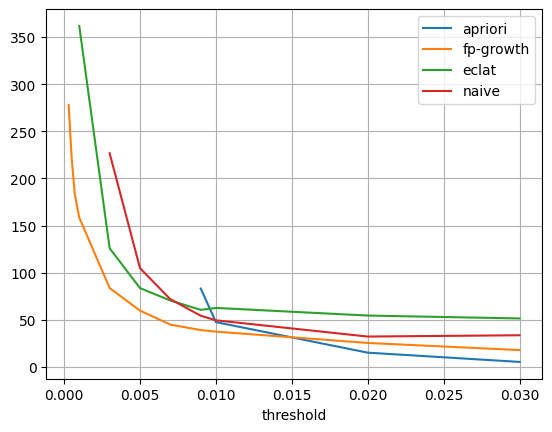

In [34]:
results.plot(x="threshold", y=["apriori", "fp-growth", "eclat", "naive"], grid=True)

We can see that *Apriori* is the one that has the better results for a bigger threshold. However the time it takes, rapidly surpasses all the other algorithms, and as we said it consumed more memory than the others too. It is not a good option, and we did not explore it beyond the support value of $0.009$ since the memory consumption was too high. <br>
*Eclat* started with a performance worse than the *'Naive'* as we lowered the threshold it got better performance than the later model.<br>
*FPGrowth* seems to have a good has a good trend and is better than *Eclat* and *'Naive'*<br>

In [ ]:
fi = fpgrowth(binary_orders, 0.0002)